In [77]:
import pandas as pd
import numpy as np
import cartiflette
import matplotlib.pyplot as plt
import geopandas as gpd
import itertools

from cartiflette import carti_download

# IMPORTATIONS JEUX DE DONNEES

Les jeux de données proviennent du site data.gouv et ont été mis à la disposition du public par l'Autorité Nationale des Jeux, chargée de la régulation des jeux d'argent en France depuis 2010, l'ouverture du marché des paris sportifs à la concurrence (https://fr.wikipedia.org/wiki/Autorit%C3%A9_nationale_des_jeux).

In [78]:
marches = pd.read_csv("https://static.data.gouv.fr/resources/donnees-sur-le-marche-des-jeux-en-ligne-paris-sportifs-hippiques-et-poker-de-2010-a-2024/20251208-095023/open-data-donnees-marche-des-jah-en-ligne-2024.csv", sep=";", encoding="latin-1")

**Description**

Le marché des jeux en ligne s'est ouvert à la concurrence en 2010. Les opérateurs agréés par l'Arjel puis par l'ANJ (Autorité nationale des jeux), depuis sa création en 2020, peuvent proposer des offres de jeux en ligne pour les paris sportifs, les paris hippiques et le poker. La liste des opérateurs agréés est disponible sur le site de l'ANJ. Les opérateurs agréés communiquent régulièrement à l'ANJ les données du marché des jeux en ligne telles que : le nombre de comptes joueurs actifs, les mises, le produit but des jeux (chiffre d'affaires), la répartition des mises se sports, etc.

In [79]:
nb_joueurs = pd.read_csv("https://www.data.gouv.fr/api/1/datasets/r/bee3f217-e4d8-49aa-8985-d66c133de9b0", sep=";", encoding="latin-1")

**Description**

Ce fichier détaille par département la part de joueurs de jeux d'argent en ligne, par segment de jeu, rapportée à sa population adulte en 2024.

In [80]:
interdit = pd.read_csv("https://www.data.gouv.fr/api/1/datasets/r/ac2d4242-4c0f-4415-b88e-558b8e8e5221", sep=";", encoding="latin-1")

**Description**

Répartition géographique des personnes faisant l'objet d'une interdiction volontaire de jeux depuis 2023

L’interdiction volontaire de jeux est une démarche strictement personnelle qui s’effectue en ligne auprès de l’ANJ.

Elle a pour conséquence d’interdire :

d’entrer dans un casino ou un club de jeux,
d’accéder à un site de jeux en ligne agréé par l’ANJ (paris sportifs, paris hippiques et poker),
d’accéder aux jeux de la FDJ et du PMU réalisés avec un compte joueur.

Cette inscription est valable pour une durée de trois ans minimum. Après cette durée, les personnes peuvent demander la levée de cette interdiction.

In [81]:
shp_dep = carti_download(
      values = ["France"],
      crs = 4326,
      borders = "DEPARTEMENT",
      vectorfile_format="topojson",
      simplification=50,
      filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)

**Module de cartographie**

Ce package a été créé par des agents de l'INSEE et il contient des fonds de carte de la France.

# NETTOYAGE DES DONNEES

Le fichier interdit est bizzarement construit, donc il faut modifier sa structure pour voir les données qui nous intéressent, c'est-à-dire une colonne avec les départements, et deux autres avec le nombre d'interdits volontaires en 2023 et en 2024. Les départements sont classés par ordre décroissant du nombre de joueurs interdits volontaires. 

In [82]:
interdit = interdit.drop(columns=[interdit.columns[2], interdit.columns[3], interdit.columns[5]])
interdit = interdit.iloc[2:]
interdit = interdit.iloc[:97]
interdit.columns = ['departement', 'nb_interdit_vol_2023', 'nb_interdit_vol_2024']
interdit.head()

,departement,nb_interdit_vol_2023,nb_interdit_vol_2024
2,13,2734,3602
3,59,2605,3435
4,06,2430,3150
5,69,1778,2367
6,83,1734,2300


Les clés de département entre les différents jeux de données sont différentes, donc il faut harmoniser au mieux pour avoir des cartes précises.

In [83]:
dep_nb_joueurs = set(nb_joueurs['Numéro du Département'].dropna().unique())
dep_interdit = set(interdit['departement'].dropna().unique())
dep_shp = set(shp_dep['INSEE_DEP'].dropna().unique())

dept_numbers = sorted(set(dep_nb_joueurs | dep_interdit | dep_shp))

comparison_data = {
    'Numéro Département': dept_numbers,
    'nb_joueurs': [d in dep_nb_joueurs for d in dept_numbers],
    'interdit': [d in dep_interdit for d in dept_numbers],
    'dep_clean (cartographie)': [d in dep_shp for d in dept_numbers]
}

comparison_df = pd.DataFrame(comparison_data)

comparison_df_filtered = comparison_df[
    ~(comparison_df['nb_joueurs'] & comparison_df['interdit'] & comparison_df['dep_clean (cartographie)'])
]

# Afficher le tableau
print("TABLEAU COMPARATIF DES INCLUSIONS PAR DATAFRAME")
print("(Affichage uniquement des départements avec incohérences)")
print("=" * 80)
print(comparison_df_filtered.to_string(index=False))
print("\n")

TABLEAU COMPARATIF DES INCLUSIONS PAR DATAFRAME
(Affichage uniquement des départements avec incohérences)
Numéro Département  nb_joueurs  interdit  dep_clean (cartographie)
                01       False      True                      True
                02       False      True                      True
                03       False      True                      True
                04       False      True                      True
                05       False      True                      True
                06       False      True                      True
                07       False      True                      True
                08       False      True                      True
                09       False      True                      True
                 1        True     False                     False
                 2        True     False                     False
                20       False      True                     False
 20 (anciennement)     

Le premier élément de ce tableau nous indique qu'il faudra passer toutes les données en **numeric** pour pouvoir *merge* intelligemment par la suite. Ensuite, pour la **Corse**, trois libellés sont possibles : 20, 20 (anciennement) et 2A/2B, comme seul le *dataframe* de cartographie fait la distinction, on garde la dénomination 20 en regroupant les deux départements en *mergeant* les coordonnées cartographiques de deux départements. La question est plus complexe pour les **départements d'outre-mer** : interdit regroupe tous les départements d'outre-mer dans le numéro 97, et fait une distinction avec les autres territoires d'outre-mer du numéro 98, tandis que les autres ont des données pour chaque DOM, mais pas pour les COM. On décide de ne pas essayer d'harmoniser ces données.

In [84]:
nb_joueurs['Numéro du Département'] = nb_joueurs['Numéro du Département'].replace('20 (anciennement)', '20')
nb_joueurs['Numéro du Département'] = pd.to_numeric(nb_joueurs['Numéro du Département'], errors='coerce')
nb_joueurs['Numéro du Département'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95, 971, 972, 973, 974, 976])

In [85]:
interdit['departement'] = pd.to_numeric(interdit['departement'], errors='coerce')
interdit['departement'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98])

In [86]:
dep = shp_dep[['INSEE_DEP', 'LIBELLE_DEPARTEMENT', 'geometry']].copy()
dep['INSEE_DEP'] = dep['INSEE_DEP'].replace({'2A': '20', '2B': '20'})
dep['INSEE_DEP'] = pd.to_numeric(dep['INSEE_DEP'], errors='coerce')

dep_clean = dep.dropna(subset=['geometry', 'INSEE_DEP']).copy()

dep_clean['geometry'] = dep_clean.geometry.make_valid()

dep_clean = dep_clean.dissolve(by='INSEE_DEP', aggfunc='first')
dep_clean = dep_clean.reset_index()

dep_clean['INSEE_DEP'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95, 971, 972, 973, 974, 976])

In [87]:
joueurs_tomerge = nb_joueurs.merge(interdit, left_on='Numéro du Département', right_on='departement', how='outer')

In [88]:
joueurs_geo = joueurs_tomerge.merge(dep_clean, left_on='Numéro du Département', right_on='INSEE_DEP', how='outer')

Finalement, on renomme les variables et on met tout en *numeric*, sauf les coordonnées géographiques, et on calcule les densités pour enrichir l'information.

In [89]:
joueurs_geo.rename(columns={
    'Numéro du Département': 'num_dep1',
    'Département': 'nom_dep',
    'Nombre de Joueurs de Poker': 'nb_joueurs_po',
    'Nombre de joueurs de Paris Hippiques': 'nb_joueurs_ph',
    'Nombre de Joueurs de Paris Sportifs': 'nb_joueurs_ps',
    'Nombre de Joueurs Uniques tous segments': 'nb_joueurs_uniques',
    'Population adulte INSEE par Département': 'pop',
    'Densité Poker': 'densite_po',
    'Densité Paris Hippiques': 'densite_ph',
    'Densité Paris Sportifs': 'densite_ps',
    'departement': 'num_dep2',
    }, inplace=True)

In [90]:
cols = ['densite_po', 'densite_ps', 'densite_ph']

for col in cols:
    joueurs_geo[col] = pd.to_numeric(
        joueurs_geo[col]
            .astype(str)
            .str.replace(',', '.', regex=False)
            .str.rstrip('%'),
        errors='coerce'
    ) / 100

In [ ]:
# On complète les autres densités
joueurs_geo['densite_joueurs_uniques'] = joueurs_geo['nb_joueurs_uniques'] / joueurs_geo['pop']

joueurs_geo['nb_interdit_vol_2023'] = pd.to_numeric(joueurs_geo['nb_interdit_vol_2023'], errors='coerce')
joueurs_geo['nb_interdit_vol_2024'] = pd.to_numeric(joueurs_geo['nb_interdit_vol_2024'], errors='coerce')

joueurs_geo['densite_interdit_2023'] = joueurs_geo['nb_interdit_vol_2023'] / joueurs_geo['pop']
joueurs_geo['densite_interdit_2024'] = joueurs_geo['nb_interdit_vol_2024'] / joueurs_geo['pop']

joueurs_geo['joueurs_pour_interdit'] = joueurs_geo['nb_joueurs_uniques'] / joueurs_geo['nb_interdit_vol_2024']

In [ ]:
# On crée une ligne total pour comparer les départements à la moyenne nationale

joueurs_total = pd.DataFrame({
    'nom_dep': ['France'],
    
    # Sommes des joueurs
    'nb_joueurs_po': [joueurs_geo['nb_joueurs_po'].sum()],
    'nb_joueurs_ph': [joueurs_geo['nb_joueurs_ph'].sum()],
    'nb_joueurs_ps': [joueurs_geo['nb_joueurs_ps'].sum()],
    'nb_joueurs_uniques': [joueurs_geo['nb_joueurs_uniques'].sum()],
    
    # Somme de la population
    'pop': [joueurs_geo['pop'].sum()],
    
    # Somme des interdits
    'nb_interdit_vol_2023': [joueurs_geo['nb_interdit_vol_2023'].sum()],
    'nb_interdit_vol_2024': [joueurs_geo['nb_interdit_vol_2024'].sum()],
    
    # Densités recalculées à partir des totaux
    'densite_po': [joueurs_geo['nb_joueurs_po'].sum() / joueurs_geo['pop'].sum()],
    'densite_ph': [joueurs_geo['nb_joueurs_ph'].sum() / joueurs_geo['pop'].sum()],
    'densite_ps': [joueurs_geo['nb_joueurs_ps'].sum() / joueurs_geo['pop'].sum()],
    'densite_joueurs_uniques': [joueurs_geo['nb_joueurs_uniques'].sum() / joueurs_geo['pop'].sum()],
    'densite_interdit_2023': [joueurs_geo['nb_interdit_vol_2023'].sum() / joueurs_geo['pop'].sum()],
    'densite_interdit_2024': [joueurs_geo['nb_interdit_vol_2024'].sum() / joueurs_geo['pop'].sum()],
    'joueurs_pour_interdit': [joueurs_geo['nb_joueurs_uniques'].sum() / joueurs_geo['nb_interdit_vol_2024'].sum()],
})

,nom_dep,nb_joueurs_po,nb_joueurs_ph,nb_joueurs_ps,nb_joueurs_uniques,pop,nb_interdit_vol_2023,nb_interdit_vol_2024,densite_po,densite_ph,densite_ps,densite_joueurs_uniques,densite_interdit_2023,densite_interdit_2024,joueurs_pour_interdit
0,France,1553343.0,538415.0,3188496.0,3693650.0,53305318.0,48026.0,63988.0,0.02914,0.010101,0.059816,0.069292,0.000901,0.0012,57.724105


Pour la base de données des marchés, un peu de travail est à réaliser aussi. En particulier, il convient de transposer le *dataframe* afin d'avoir les variables en colonnes plutôt qu'en lignes. Puis, on renomme les colonnes pour simplifier les clés, et on passe toutes les données en numeric (notamment en enlevant les %) afin de créer de nouvelles colonnes à partir de celles existantes.

In [92]:
marches = marches.iloc[:26]

# Transposer le dataframe : années en lignes, catégories en colonnes
marches = marches.set_index('Catégorie/Année').T
marches.index.name = 'Année'
marches['year'] = list(range(2010, 2025))
marches = marches.reset_index()

marches = marches.rename(columns={'Nombre dopérateurs' : 'nb_op',
                                  'Nombre dagréments' : 'nb_agrements',
                                  'Nombre agréments paris sportifs' : 'nb_agrements_ps',
                                  'Nombre agréments paris hippiques' : 'nb_agrements_ph',
                                  'Nombre agréments poker' : 'nb_agrements_po',
                                  'Nombre de comptes joueurs actifs total (en milliers)' : 'CJA_total',
                                  'Nombre CJA Paris sportifs (en milliers)' : 'CJA_ps',
                                  'Nombre CJA Paris hippiques (en milliers)' : 'CJA_ph',
                                  'Nombre CJA Poker (en milliers)' : 'CJA_po',
                                  'Nombre de joueurs uniques' : 'nb_joueurs_uniques',
                                  'Mises paris sportifs (en M)' : 'mises_ps',
                                  'Mises paris hippiques (en M)' : 'mises_ph',
                                  'PBJ paris sportifs (en M)' : 'PBJ_ps',
                                  'PBJ paris hippiques (en M)' : 'PBJ_ph',
                                  'PBJ poker (en M)' : 'PBJ_po',
                                  'Budget marketing médias (en M)' : 'budget_marketing',
                                  'Part hommes PS' : 'part_mises_hommes_ps',
                                  'Part femmes PS' : 'part_mises_femmes_ps',
                                  'Part mises football' : 'part_mises_football',
                                  'Part mises tennis' : 'part_mises_tennis',
                                  'Part mises basketball' : 'part_mises_basketball',
                                  'Part mises rugby' : 'part_mises_rugby',
                                  'Part hommes PH' : 'part_mises_hommes_ph',
                                  'Part femmes PH' : 'part_mises_femmes_ph',
                                  'Part hommes PO' : 'part_hommes_po',
                                  'Part femmes PO' : 'part_femmes_po'})


cols = ['part_mises_hommes_ps', 'part_mises_femmes_ps', 'part_mises_hommes_ph', 'part_mises_femmes_ph', 
        'part_hommes_po', 'part_femmes_po', 'part_mises_football', 'part_mises_tennis', 
        'part_mises_basketball', 'part_mises_rugby']

for col in cols:
    marches[col] = pd.to_numeric(
        marches[col].astype(str).str.rstrip('%'), 
        errors='coerce'
    ) / 100

marches = marches.drop(['Année'], axis=1).apply(pd.to_numeric, errors='coerce')

marches.head()

Catégorie/Année,nb_op,nb_agrements,nb_agrements_ps,nb_agrements_ph,nb_agrements_po,CJA_total,CJA_ps,CJA_ph,CJA_po,nb_joueurs_uniques,...,part_mises_femmes_ps,part_mises_hommes_ph,part_mises_femmes_ph,part_hommes_po,part_femmes_po,part_mises_football,part_mises_tennis,part_mises_basketball,part_mises_rugby,year
0,35,48,15,8,25,2058,819,365,1188,NaN,...,0.08,0.81,0.19,0.91,0.09,NaN,NaN,NaN,NaN,2010
1,32,48,16,9,23,2325,705,502,1686,NaN,...,0.08,0.80,0.20,0.89,0.11,NaN,NaN,NaN,NaN,2011
2,30,33,9,8,16,2229,765,509,1713,NaN,...,0.08,0.81,0.19,0.88,0.12,0.59,0.19,0.08,0.03,2012
3,21,30,9,8,13,2142,842,496,1240,NaN,...,0.08,0.81,0.19,0.88,0.12,0.61,0.19,0.09,0.03,2013
4,16,31,11,8,12,2320,1142,488,1157,NaN,...,0.07,0.83,0.17,0.89,0.11,0.63,0.16,0.10,0.03,2014


In [ ]:
# On met dans les bons ordres de grandeur
for col in ['CJA_ps', 'CJA_ph', 'CJA_po']:
    marches[col] = marches[col] * 1000

for col in ['mises_ps', 'mises_ph', 'PBJ_ps', 'PBJ_ph', 'PBJ_po', 'budget_marketing']:
    marches[col] = marches[col] * 1000000

In [96]:
# La part des mises consacrées aux autres sports
marches['part_mises_autres_sports'] = 1 - (marches['part_mises_football'] + marches['part_mises_tennis'] + marches['part_mises_basketball'] + marches['part_mises_rugby'])

# Le PBJ total
marches['PBJ_total'] = marches['PBJ_ps'] + marches['PBJ_ph'] + marches['PBJ_po']

# A partir des mises et des parts, on calcule les mises par sport et par genre
cols_ps = ['part_mises_hommes_ps', 'part_mises_femmes_ps', 'part_mises_football', 'part_mises_tennis', 'part_mises_basketball', 'part_mises_rugby', 'part_mises_autres_sports']

for col in cols_ps:
    cible = col.replace('part_mises_', 'mises_', 1)
    marches[cible] = marches[col] * marches['mises_ps']

for col in ['part_mises_hommes_ph', 'part_mises_femmes_ph']:
    cible = col.replace('part_mises_', 'mises_', 1)
    marches[cible] = marches[col] * marches['mises_ph']

# On calcule des ratios utiles
# Le nombre de comptes joueurs actifs par rapport au produit brut de jeu
# C'est-à-dire combien de joueurs génèrent en moyenne un euro de PBJ
marches['CJA_PBJ_PS'] = marches['CJA_ps'] / marches['PBJ_ps']
marches['CJA_PBJ_PH'] = marches['CJA_ph'] / marches['PBJ_ph']
marches['CJA_PBJ_PO'] = marches['CJA_po'] / marches['PBJ_po']
marches['CJA_PBJ_tot'] = marches['CJA_total'] / marches['PBJ_total']

# Le montant de mises par compte joueur actif
marches['Mises_per_CJA_ps'] = marches['mises_ps'] / marches['CJA_ps']
marches['Mises_per_CJA_ph'] = marches['mises_ph'] / marches['CJA_ph']

# Combien faut-il de mises pour générer un euro de PBJ ?
marches['Mises_PBJ_ps'] = marches['mises_ps'] / marches['PBJ_ps']
marches['taux_retour_ps'] = (1-marches['PBJ_ps'] / marches['mises_ps'])*100
marches['Mises_PBJ_ph'] = marches['mises_ph'] / marches['PBJ_ph']
marches['taux_retour_ph'] = (1-marches['PBJ_ph'] / marches['mises_ph'])*100

# VISUALISATION DES DONNEES

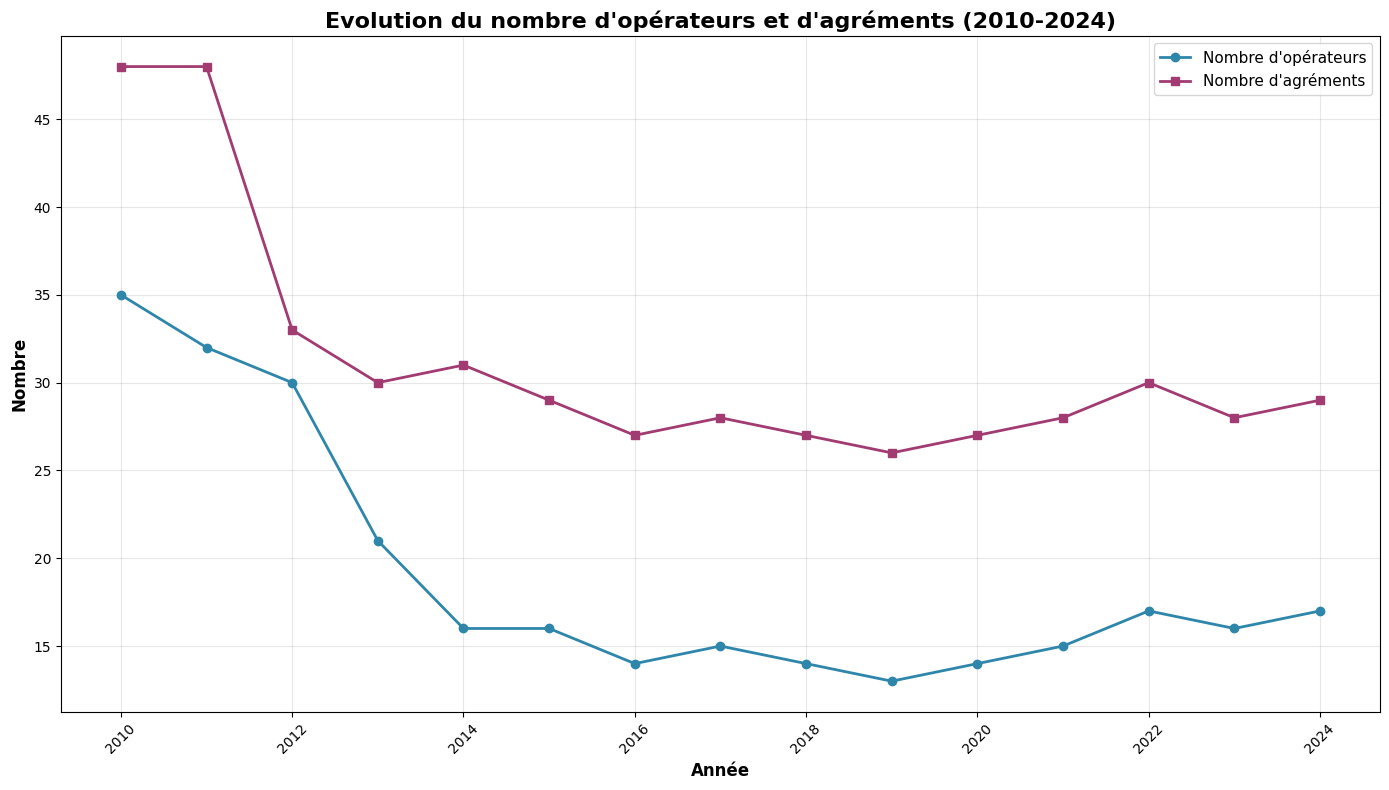

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(marches['year'], marches['nb_op'], marker='o', linewidth=2, label="Nombre d'opérateurs", color='#2E86AB')
ax.plot(marches['year'], marches['nb_agrements'], marker='s', linewidth=2, label="Nombre d'agréments", color='#A23B72')

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre', fontsize=12, fontweight='bold')
ax.set_title("Evolution du nombre d'opérateurs et d'agréments (2010-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Les agréments concernent les autorisations délivrées par l'ANJ pour qu'une entreprise offre des marchés de jeux d'argent, qui ne sont pas des jeux de hasard, et les opérateurs sont les entreprises qui ont le droit d'utiliser cet agrément. Il y a plus d'agréments que d'opérateurs, car plusieurs opérateurs ont un agrément dans plusieurs secteurs, c'est le cas de Parions Sport En Ligne qui propose des marchés en paris sportifs, en paris hippiques et en poker.

En 15 ans, le nombre d'agréments et le nombre d'opérateurs ont suivi la même tendance, à savoir une baisse de 2010 à 2013/2014 puis un équilibre autour de 15 opérateurs pour un peu plus de 25 agréments, et à partir de 2018 une augmentation lente avec environ 1 opérateur de plus chaque année. 

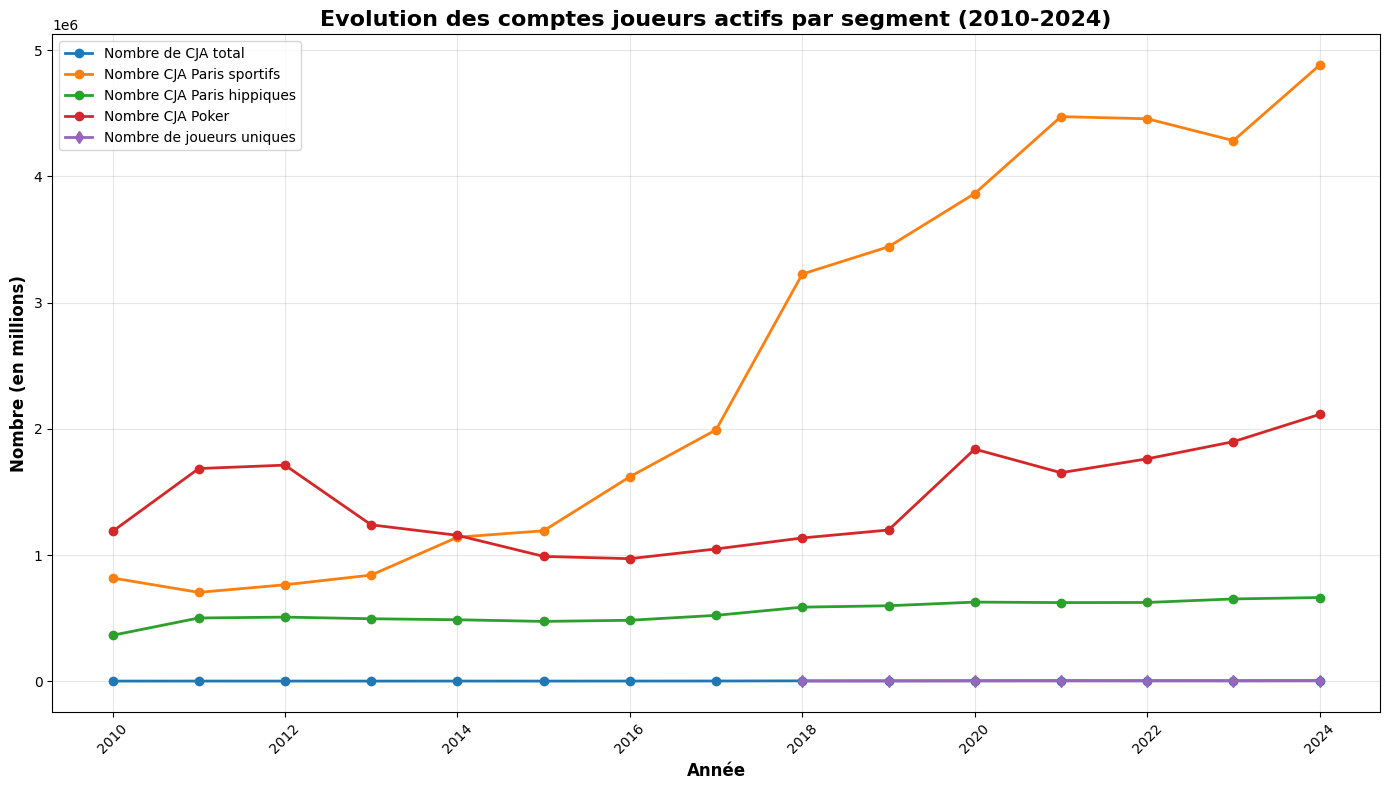

In [28]:
# Comptes joueurs actifs
categories_cja = [
    'CJA_total',
    'CJA_ps',
    'CJA_ph',
    'CJA_po',
    'nb_joueurs_uniques'
]

labels_cja = [
    'Nombre de CJA total',
    'Nombre CJA Paris sportifs',
    'Nombre CJA Paris hippiques',
    'Nombre CJA Poker',
    'Nombre de joueurs uniques'
]

marker_cja = ['o', 'o', 'o', 'o', 'd']

fig, ax = plt.subplots(figsize=(14, 8))

for categorie in categories_cja:
    valeurs = marches[categorie].values
    ax.plot(marches['year'], valeurs, marker=marker_cja[categories_cja.index(categorie)], linewidth=2, label=labels_cja[categories_cja.index(categorie)])

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre (en millions)', fontsize=12, fontweight='bold')
ax.set_title('Evolution des comptes joueurs actifs par segment (2010-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Au niveau des joueurs, le nombre de CJA pour les paris sportifs a augmenté de manière continue depuis 2014, au moment où le marché a semblé se stabiliser sur les opérateurs, tandis que le nombre de joueurs de poker connaît une évolution contrastée, c'est-à-dire une baisse de ses nombres de comptes entre 2011 et 2016, puis une augmentation progressive jusqu'aujourd'hui, et enfin, le nombre de joueurs de paris hippiques est constant tout au long de la période.

Il est intéressant de noter que de la même manière que les opérateurs officient sur plusieurs segments des jeux de hasard, les joueurs sont aussi présents sur ces segments, en voyant que le nombre de CJA pour les paris sportifs est supérieur au nombre de joueurs uniques. 

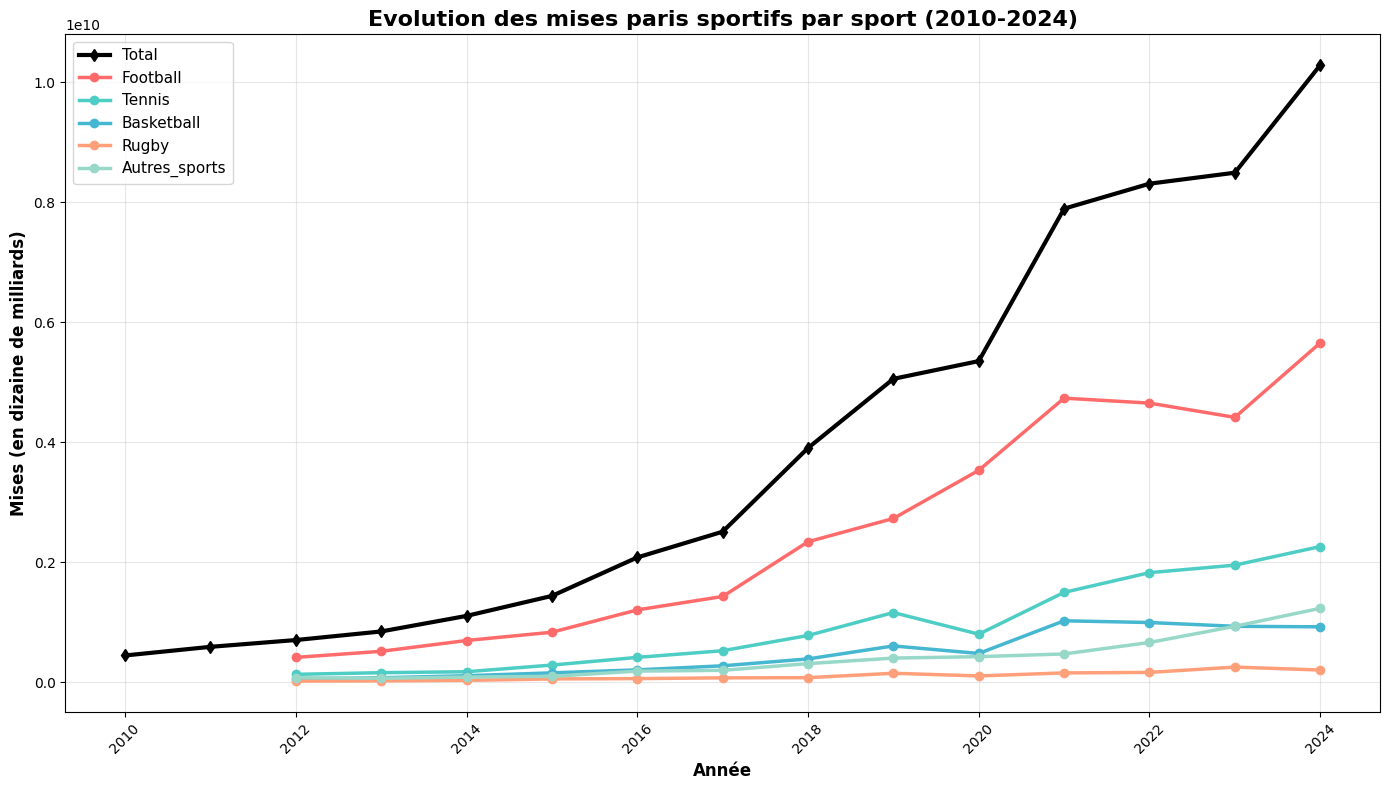

In [34]:
# Mises par sport
sports = ['football', 'tennis', 'basketball', 'rugby', 'autres_sports']
couleurs_sports = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

fig, ax = plt.subplots(figsize=(14, 8))

valeurs_total = marches['mises_ps'].values
ax.plot(marches['year'], valeurs_total, marker='d', linewidth=3, label='Total', color='#000000', zorder=10)

for idx, sport in enumerate(sports):
    categorie = f'mises_{sport}'
    valeurs = marches[categorie].values
    ax.plot(marches['year'], valeurs, marker='o', linewidth=2.5, label=sport.capitalize(), color=couleurs_sports[idx])

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Mises (en dizaine de milliards)', fontsize=12, fontweight='bold')
ax.set_title('Evolution des mises paris sportifs par sport (2010-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En lien avec l'augmentation totale du nombre de joueurs, le montant total des mises a aussi considérablement augmenté en 15 ans, dépassant en 2024 10 milliards d'euros tous segments confondus, bien que cette augmentation soit largement soutenue par les mises sur le football. 

Il est intéressant de noter sur ce graphique que pour la première fois en 2023, les mises sur les autres sports dépassent celles sur le basketball et celles sur le rugby, ce qui montre l'attrait de nouveaux marchés sur des sports moins traditionnels et moins visionnés.

De plus, le football a eu l'air de ne pas souffrir de l'année 2020, à l'inverse des autres sports, en particulier le tennis, dont les compétitions ont été arrêtées pendant le confinement. On peut voir ce constat, sur le graphique juste en dessous qui empile les aires de chaque sport.

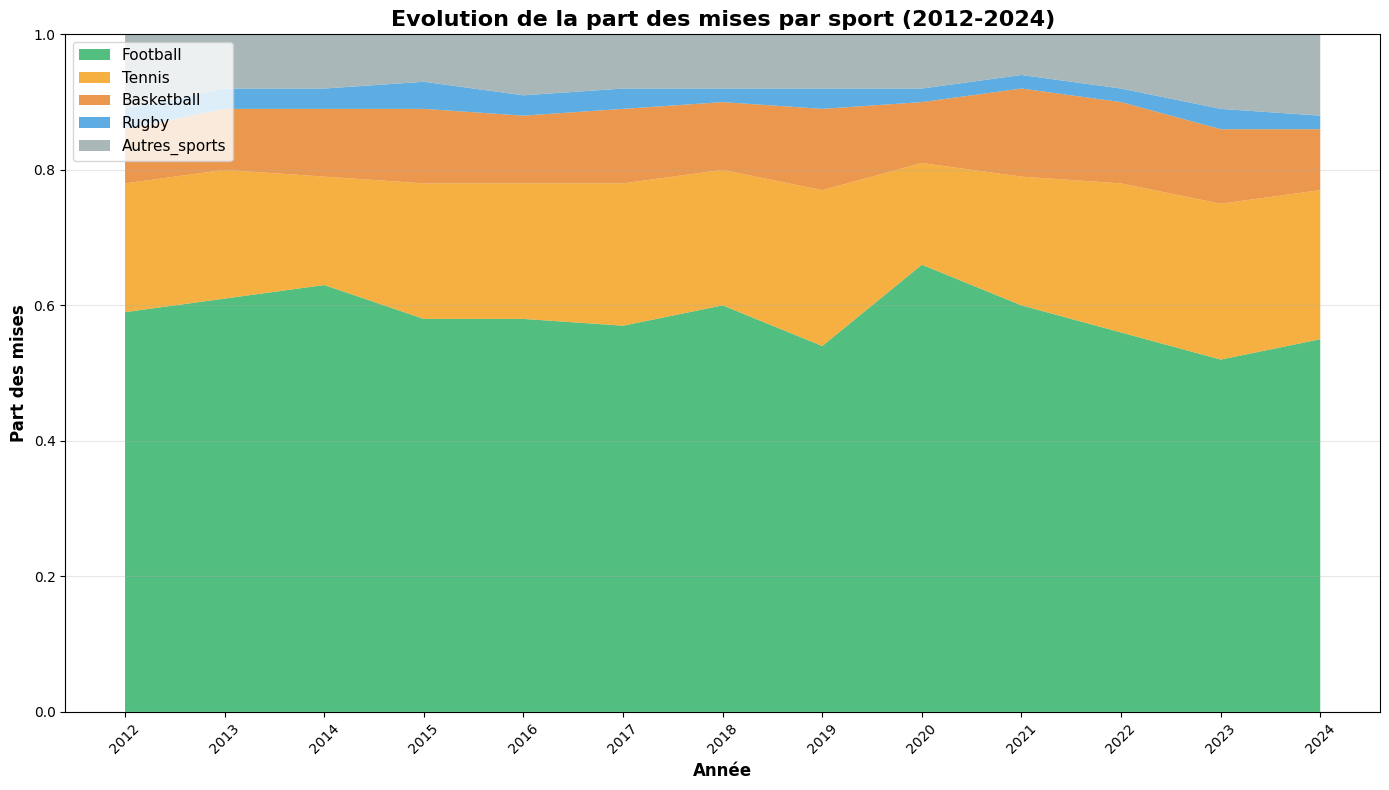

In [22]:
couleurs_sports = ['#27ae60', '#f39c12', '#e67e22', '#3498db', '#95a5a6']

# Filtrer les années à partir de 2012
marches_recent = marches[marches['year'] >= 2012].copy()
x_vals = np.arange(len(marches_recent['year']))

fig, ax = plt.subplots(figsize=(14, 8))

data_proportions = [marches_recent[f'part_mises_{sport}'].values for sport in sports]
ax.stackplot(
    x_vals,
    data_proportions,
    labels=[sport.capitalize() for sport in sports],
    colors=couleurs_sports,
    alpha=0.8
)

ax.set_xticks(x_vals)
ax.set_xticklabels(marches_recent['year'], rotation=45)
ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Part des mises', fontsize=12, fontweight='bold')
ax.set_title('Evolution de la part des mises par sport (2012-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

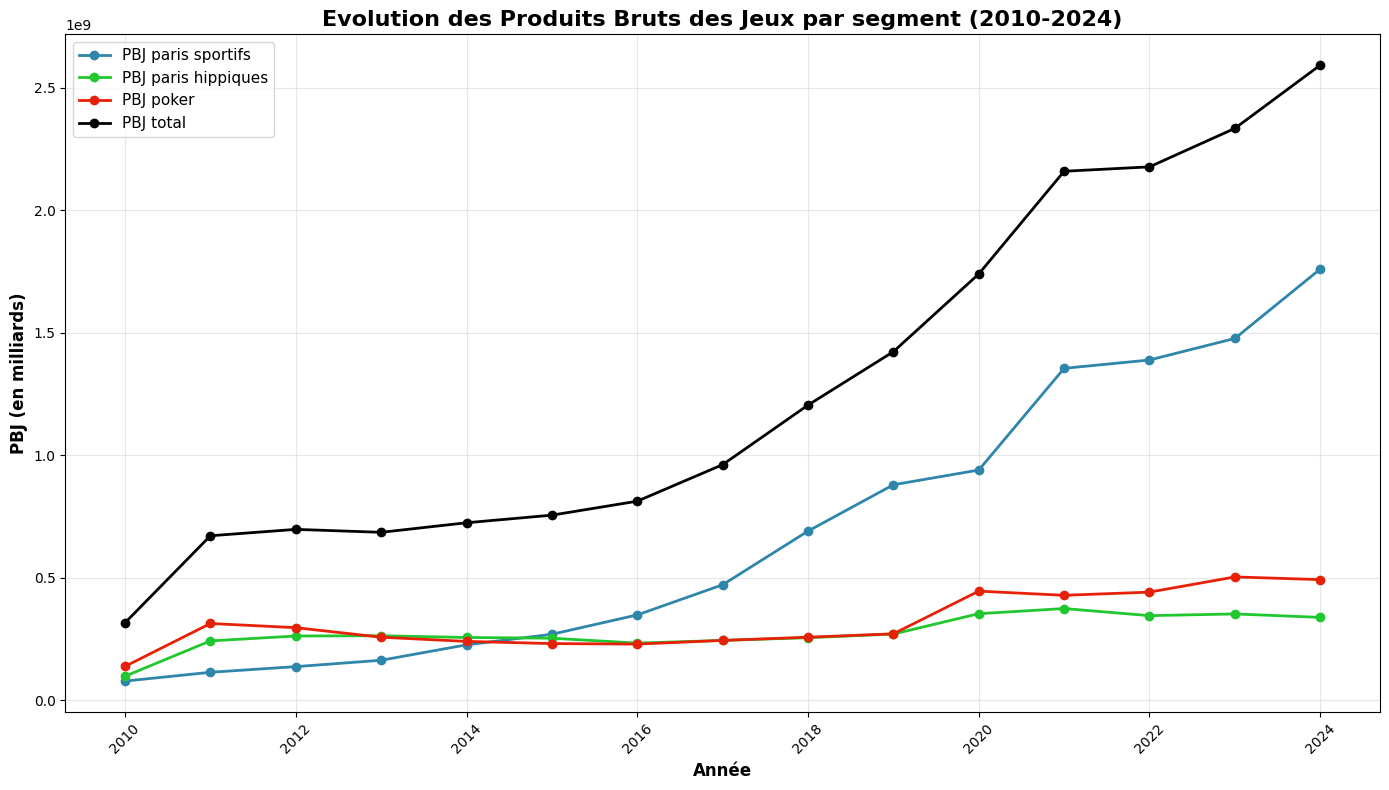

In [41]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(marches['year'], marches['PBJ_ps'], marker='o', linewidth=2, label="PBJ paris sportifs", color='#2E86AB')
ax.plot(marches['year'], marches['PBJ_ph'], marker='o', linewidth=2, label="PBJ paris hippiques", color="#20C72E")
ax.plot(marches['year'], marches['PBJ_po'], marker='o', linewidth=2, label="PBJ poker", color="#E62107")
ax.plot(marches['year'], marches['PBJ_total'], marker='o', linewidth=2, label="PBJ total", color="#000200")

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('PBJ (en milliards)', fontsize=12, fontweight='bold')
ax.set_title("Evolution des Produits Bruts des Jeux par segment (2010-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Les PBJ confirment l'essor du marché des jeux de hasard après la période de stabilisation entre l'ouverture à la concurrence en 2010 et l'année 2015 à peu près, et la croissance est largement soutenue, encore une fois, par les paris sportifs. En effet, entre 2010 et 2014 les PBJ des paris hippiques sont supérieurs à ceux des paris sportifs, et ils sont en 2024 presque 4 fois inférieurs

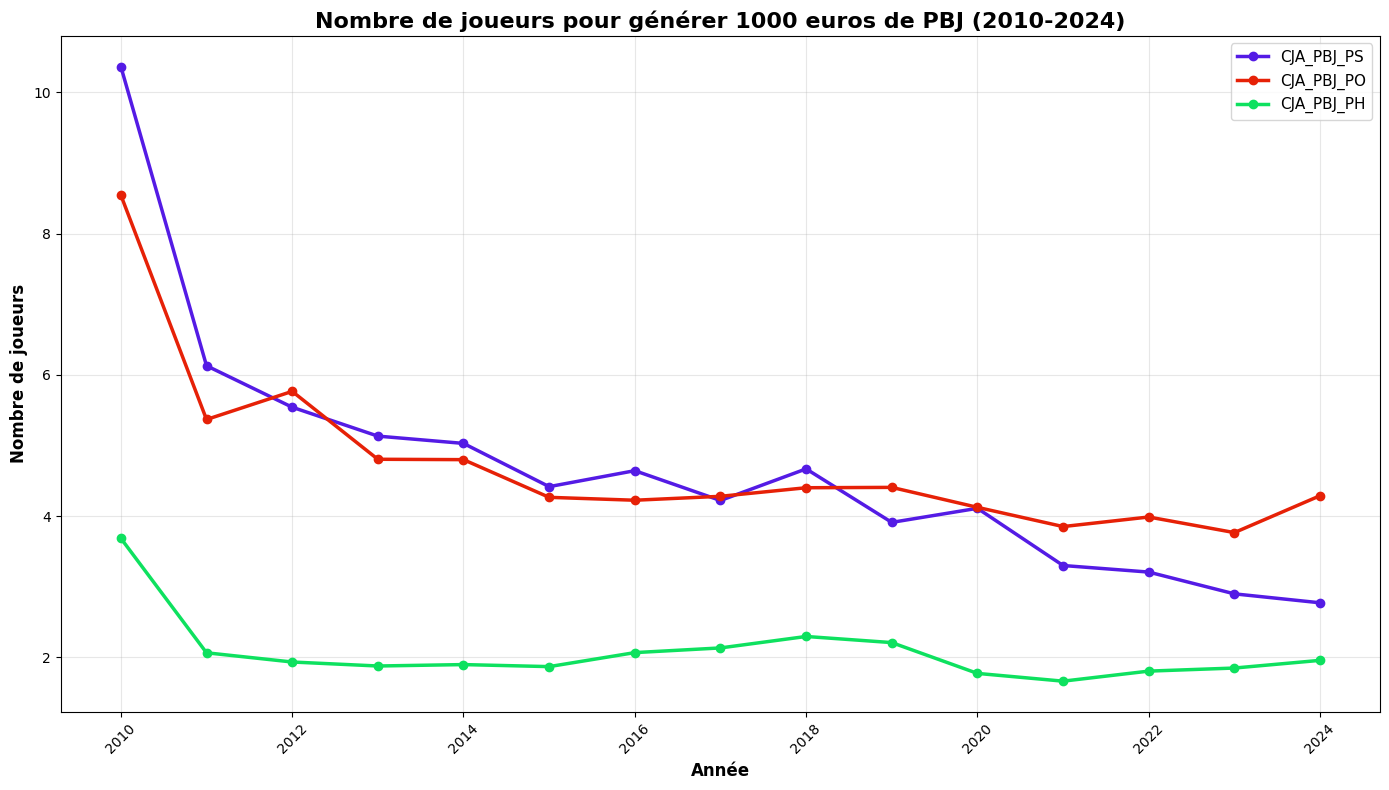

In [39]:
cols = ['CJA_PBJ_PS', 'CJA_PBJ_PO', 'CJA_PBJ_PH']
couleurs = ["#541BE5", "#E62107", "#0EE15F"]

fig, ax = plt.subplots(figsize=(14, 8))

for col in cols:
    valeur = marches[col].values*1000
    ax.plot(marches['year'], valeur, label=col, marker='o', color=couleurs[cols.index(col)], linewidth=2.5)

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel("Nombre de joueurs", fontsize=12, fontweight='bold')
ax.set_title("Nombre de joueurs pour générer 1000 euros de PBJ (2010-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

L'indicateur CJA_PBJ mesure le nombre de joueurs nécessaires pour produire 1 000 euros de produit brut des jeux sur une année. En 2010, il fallait entre 8 et 9 joueurs de poker pour générer 1 000 euros de PBJ au poker, tandis qu'il en faut deux fois moins en 2024. L'évolution de ce ratio est intéressante, car, comme on l'a vu, le nombre de joueurs augmente de même que la quantité de PBJ, donc le caractère décroissant des courbes provient d'une augmentation plus forte du PBJ par rapport à l'augmentation du nombre de joueurs. Cela peut être le signe d'une intensification du jeu pour les joueurs en général, ou alors l'explosion des mises pour une minorité de joueurs, mais cela peut être aussi le signe d'un meilleur *yield management* et ciblage des profils de joueurs par les opérateurs. Il est difficile de tirer des conclusions à partir de ce seul graphique, c'est pourquoi on regarde aussi l'évolution de l'indicateur Mises_per_CJA.

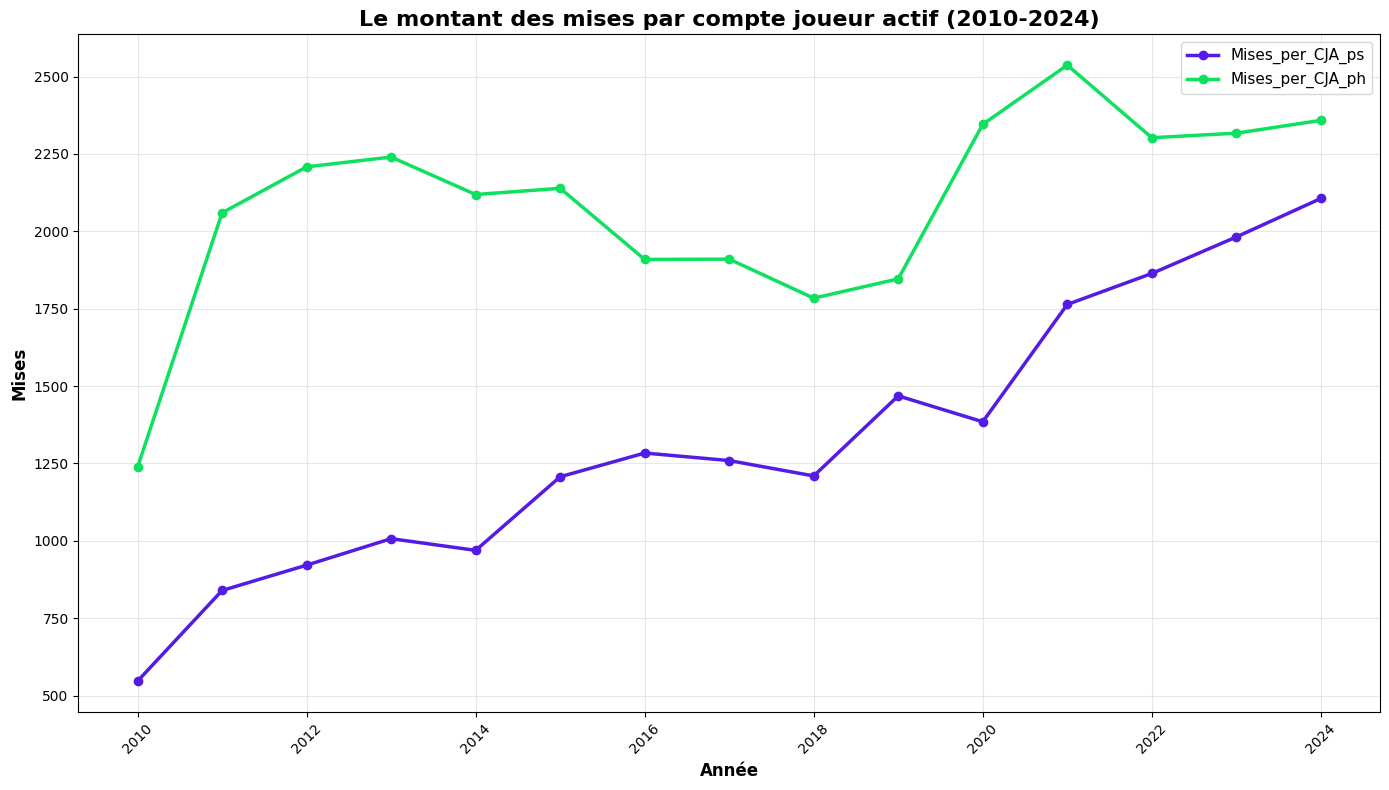

In [40]:
cols = ['Mises_per_CJA_ps', 'Mises_per_CJA_ph']
couleurs = ["#541BE5", "#0EE15F"]

fig, ax = plt.subplots(figsize=(14, 8))

for col in cols:
    valeur = marches[col].values
    ax.plot(marches['year'], valeur, label=col, marker='o', color=couleurs[cols.index(col)], linewidth=2.5)

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel("Mises", fontsize=12, fontweight='bold')
ax.set_title("Le montant des mises par compte joueur actif (2010-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Pour les paris sportifs, une tendance claire se distingue la mise moyenne par joueur par an augmente continuellement sur la période, passant de 500 euros par joueur pour l'année 2010 à plus de 2000 euros par joueur pour l'année 2024, avec quelques petits reculs sur la période, notamment en 2020. Cet indicateur est une moyenne, donc il ne dit rien des écarts à la moyenne, et il est tout à fait possible d'avoir une concentration de très gros joueurs qui tire cette moyenne à la hausse par rapport à beaucoup de joueurs peu actifs.

Cependant, il semblerait que l'hypothèse d'une intensification du jeu chez les joueurs ne soit pas excluable, même si on aimerait pousser l'analyse de ce phénomène avec des données moins agrégées au niveau des joueurs.

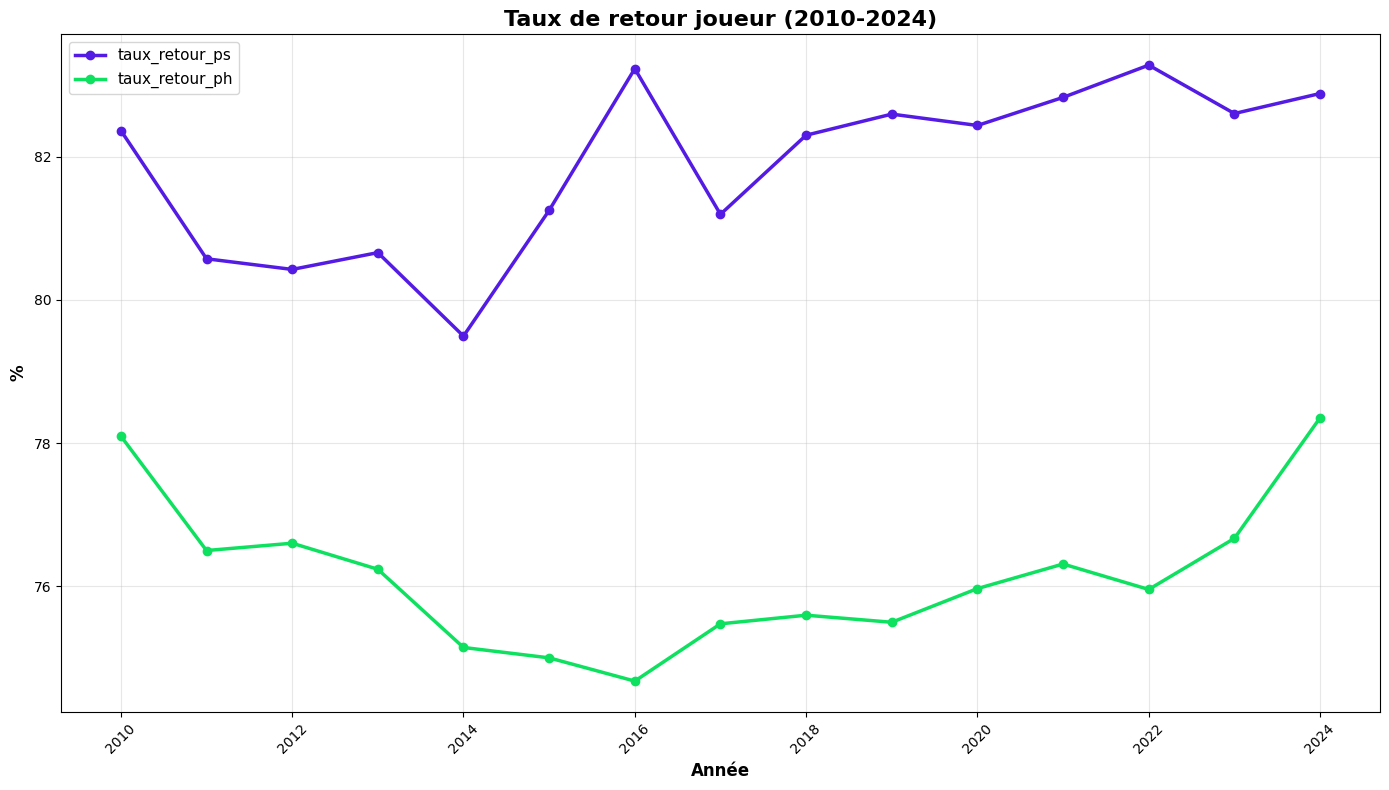

In [52]:
cols = ['taux_retour_ps', 'taux_retour_ph']
couleurs = ["#541BE5", "#0EE15F"]

fig, ax = plt.subplots(figsize=(14, 8))

for col in cols:
    valeur = marches[col].values
    ax.plot(marches['year'], valeur, label=col, marker='o', color=couleurs[cols.index(col)], linewidth=2.5)

ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel("%", fontsize=12, fontweight='bold')
ax.set_title("Taux de retour joueur (2010-2024)", fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Enfin, le taux de retour joueurs, c'est-à-dire le montant reversé aux joueurs, se situe aux alentours de 82% pour les paris sportifs et 76% pour les paris hippiques. On note que depuis 2018 ce taux approche par le bas 85%, qui est la limite légale posée par l'ANJ. Cette question est fondamentale pour les opérateurs car elle touche à la marge, et pour les paris sportifs le TRJ est stratégique en cela qu'une évolution conjointe à une augmentation de l'activité de jeu est de réduire la marge (dont la perte est compensée par la quantité de jeu) afin de garantir l'attractivité du jeu, fidéliser les clients sur un marché hautement concurrentiel.

En revanche, du point de vue de l'ANJ, un TRJ trop élevé peut signifier une intensification du jeu à long-terme tandis que le TRJ n'est pas stable dans le temps.

# CARTOGRAPHIE

Dans cette partie, on analyse à l'aide de cartes les données qui sont disponibles au niveau départemental. Les cartes sont générées pour le nombre de joueurs uniques, mais il serait tout à fait possible de regarder les données par segment : paris hippiques, paris sportifs et poker.

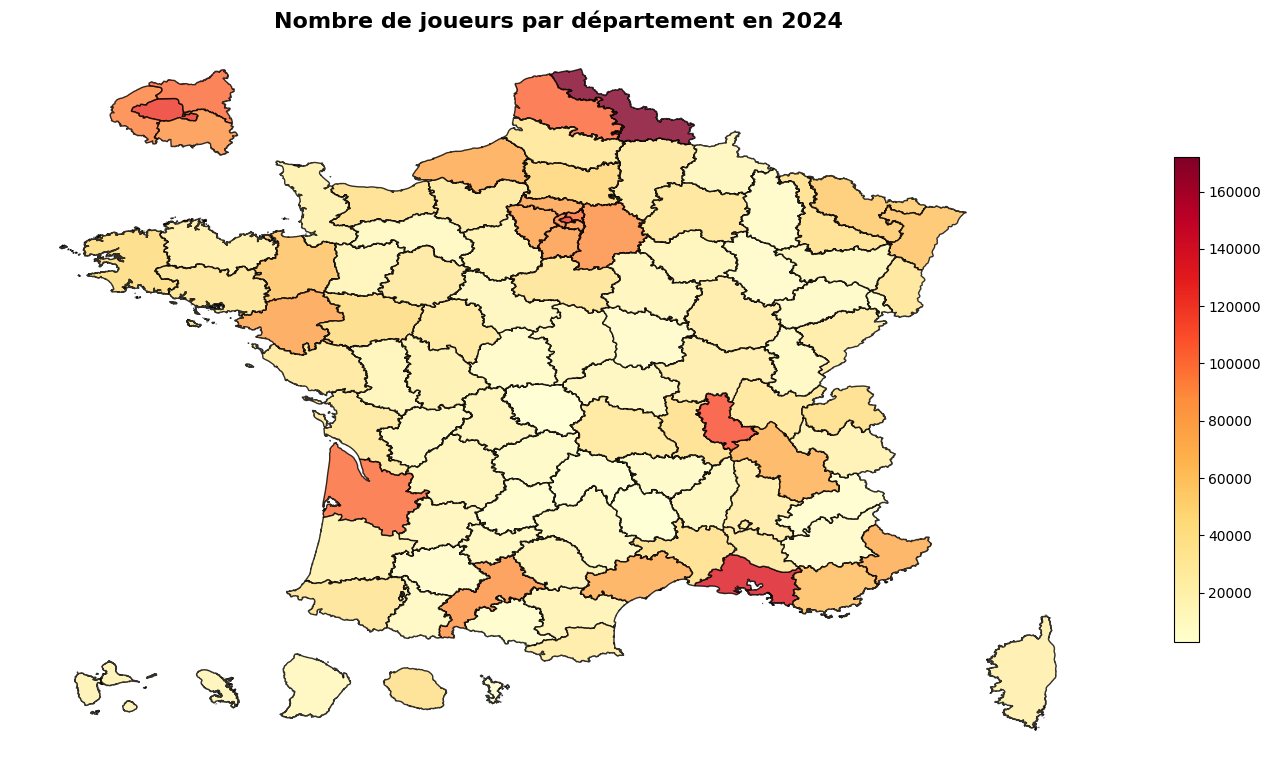

Top 5 des départements en 2024 avec le plus de joueurs:
             nom_dep  nb_joueurs_uniques
58              Nord            172101.0
12  Bouches-du-Rhône            133844.0
74             Paris            121106.0
68             Rhône            111359.0
61     Pas-de-Calais            102169.0


  nom_dep  nb_joueurs_uniques
0  France           3693650.0


In [ ]:
top_5_joueurs = joueurs_geo.nlargest(5, 'nb_joueurs_uniques')[['nom_dep', 'nb_joueurs_uniques']]

# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['nb_joueurs_uniques'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='nb_joueurs_uniques',
    ax=ax,
    legend=True,
    legend_kwds={'shrink': 0.5},
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Nombre de joueurs par département en 2024', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 5 des départements en 2024 avec le plus de joueurs:")
print(top_5_joueurs.to_string())
print("\n")
print(joueurs_total[['nom_dep', 'nb_joueurs_uniques']])

Cette carte montre très nettement des disparités entre les départements en termes de quantité de joueurs, notamment ceux où il y a des grandes villes concentrent plus de joueurs (Paris, Lille, Marseille, Lyon), et beaucoup de départements ont moins de 20 000 joueurs sur leur territoire.

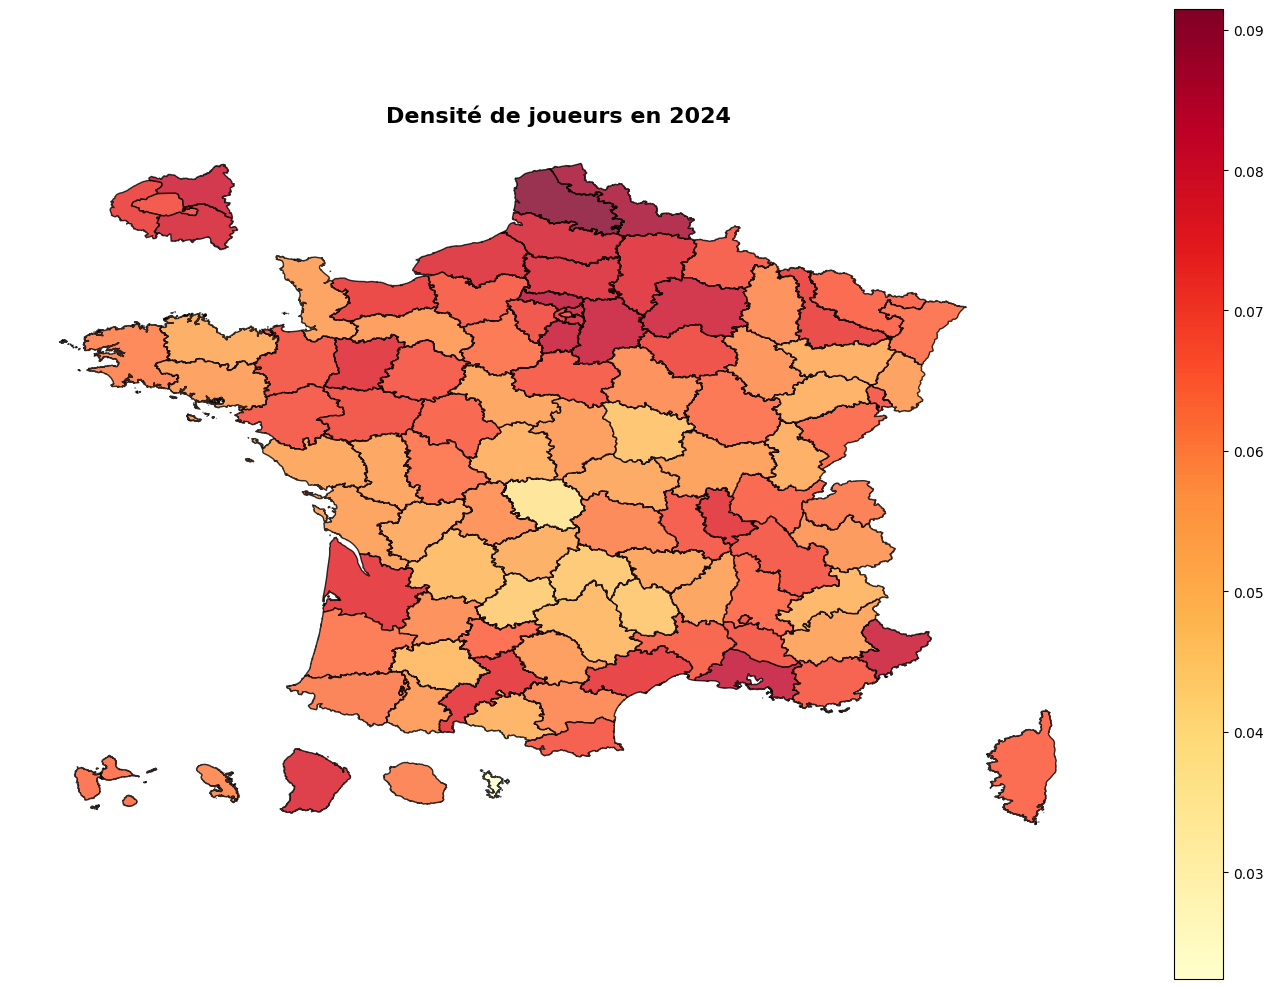

Top 5 des départements avec la plus grosse densité de joueurs:
             nom_dep  densite_joueurs_uniques  nb_joueurs_uniques
61     Pas-de-Calais                 0.091463            102169.0
58              Nord                 0.086504            172101.0
94        Val-d'Oise                 0.083500             78239.0
12  Bouches-du-Rhône                 0.082082            133844.0
90           Essonne                 0.081187             80896.0


  nom_dep  densite_joueurs_uniques
0  France                 0.069292


In [124]:
top_5_densité = joueurs_geo.nlargest(5, 'densite_joueurs_uniques')[['nom_dep', 'densite_joueurs_uniques', 'nb_joueurs_uniques']]


# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['densite_joueurs_uniques'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='densite_joueurs_uniques',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Densité de joueurs en 2024', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 5 des départements avec la plus grosse densité de joueurs:")
print(top_5_densité.to_string())
print("\n")
print(joueurs_total[['nom_dep', 'densite_joueurs_uniques']])

Quand on pondère le nombre de joueurs par la population du département, les résultats sont nettement moins lisible en termes de disparités territoriales. 

Au centre de la France, en Bretagne, dans l'Est et à Mayotte, la densité de joueurs est plus faible qu'ailleurs, aux alentours de 5 joueurs pour 100 habitants. Dans le sud-est, à Paris et dans le nord, la densité de joueurs est plus forte, de 8 à 9 joueurs pour 100 habitants. La densité au niveau nationale est 7 joueurs pour 100 habitants.

En ce qui concerne les départements des grandes villes identifiées précédemment, le nombre de joueurs coïncide bien avec une densité plus forte, ce qui nous fait faire l'hypothèse que les jeux d'argent sont plutôt des phénomènes urbains.

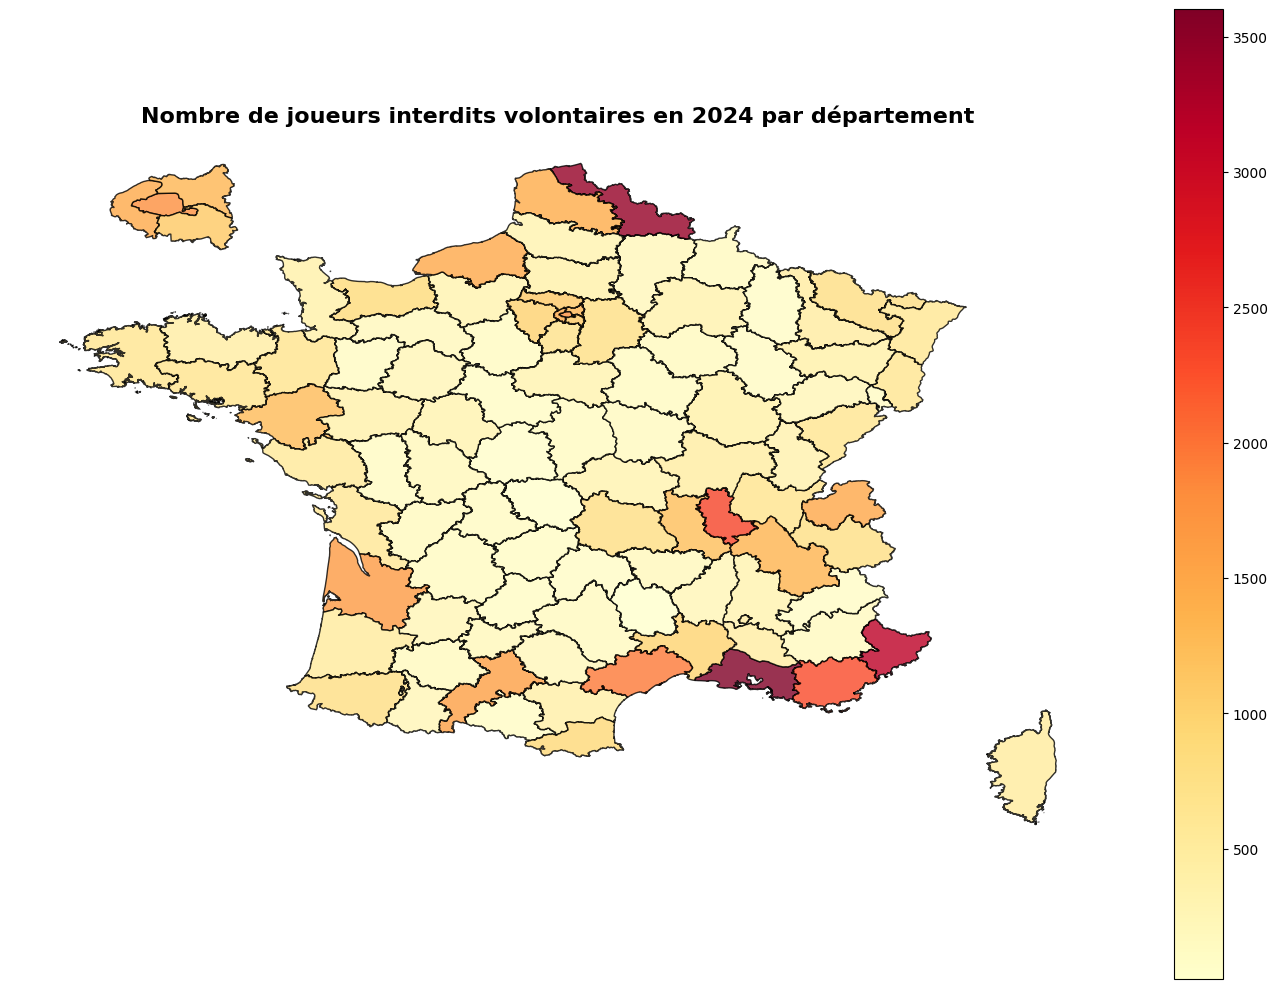

Top 5 des départements avec le plus d'interdits volontaires en 2024:
             nom_dep  nb_interdit_vol_2024
12  Bouches-du-Rhône                3602.0
58              Nord                3435.0
5    Alpes-Maritimes                3150.0
68             Rhône                2367.0
82               Var                2300.0


  nom_dep  nb_interdit_vol_2024
0  France               63988.0


In [118]:
top_5_interdit = joueurs_geo.nlargest(5, 'nb_interdit_vol_2024')[['nom_dep', 'nb_interdit_vol_2024']]

# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['nb_interdit_vol_2024'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='nb_interdit_vol_2024',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Nombre de joueurs interdits volontaires en 2024 par département', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 5 des départements avec le plus d'interdits volontaires en 2024:")
print(top_5_interdit.to_string())
print("\n")
print(joueurs_total[['nom_dep', 'nb_interdit_vol_2024']])

La carte ci-dessus recense les personnes interdites volontaires en France par département. C'est une procéudre personnelle, c'est-à-dire à la démarche de l'intéressé(e), pour les joueurs souhaitant *"se protéger contre les risques liés à leur pratique excessive du jeu d’argent (difficultés financières, troubles psychologiques liés à l’addiction, isolement, etc.)"* (https://anj.fr/interdiction-volontaire-de-jeux-un-nouveau-service-en-ligne-avec-une-experience-plus-fluide). L'ANJ a repris la gestion de ce fichier en 2021, et depuis le nombre de personnes inscrites ne cesse d'augmenter, et cela peut notamment être dû à une procédure simplifiée depuis sa mise en place et une publicité plus grande auprès du public. Par ailleurs, cela peut aussi être dû à une intensification du jeu, comme on a pu l'identifier dans la partie précédente.

Parmi les départements qui comportent le plus d'interdits volontaires, on trouve des départements qui figurent parmi les départements les plus joueurs : Bouches-du-Rhone, Nord et Rhone. L'arc du sud-est ressort étonnament dans le territoire, et on peut faire l'hypothèse que cela est du aux casinos plutôt qu'aux jeux en ligne, en particulier il y en a 12 dans le seul département des Alpes-Maritimes pour 200 en France.

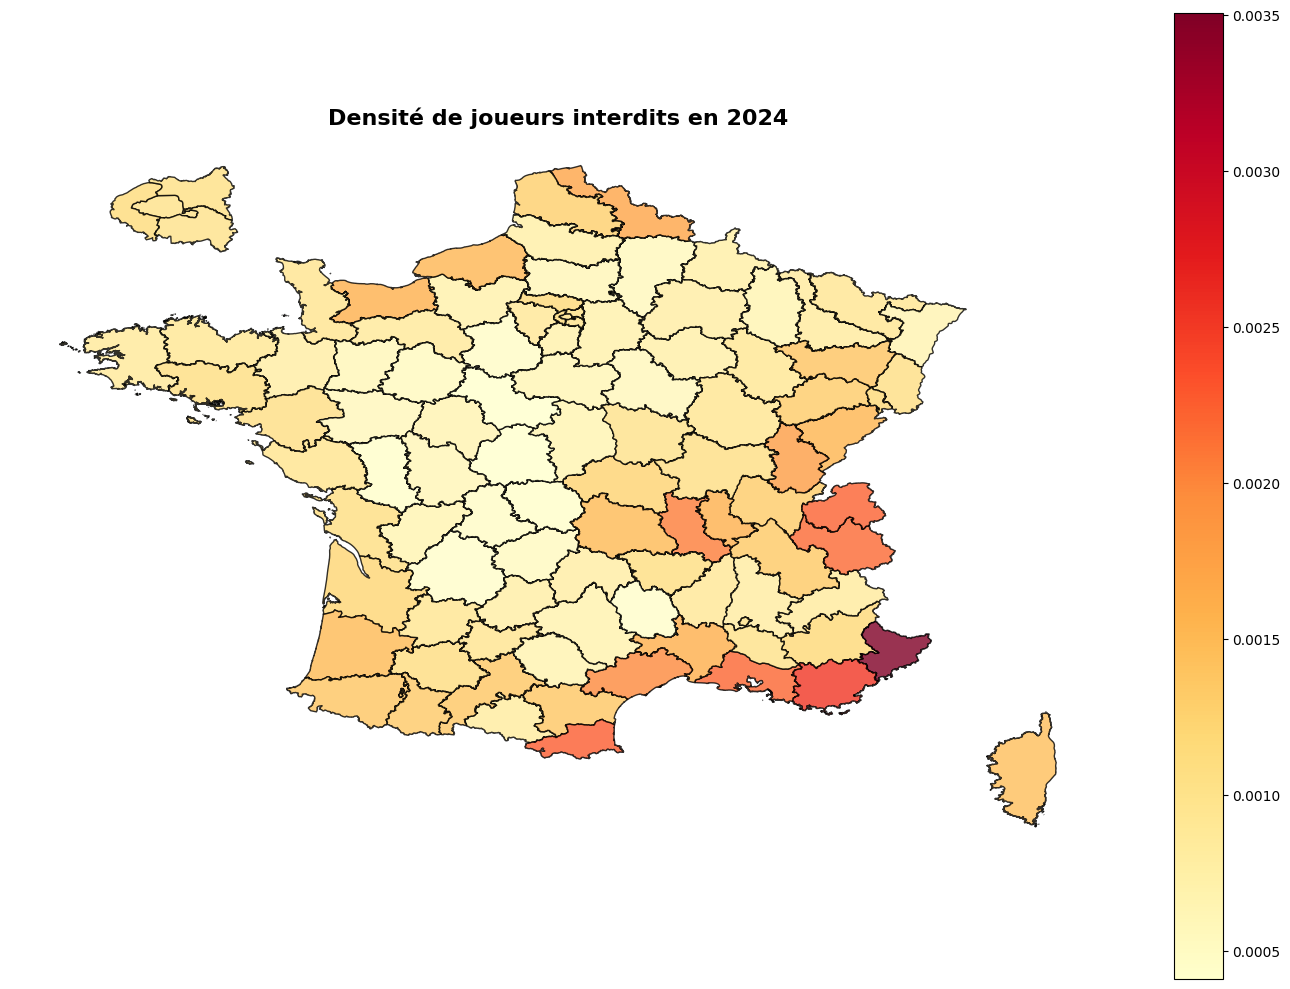

Top 5 des départements avec le plus d'interdits volontaires en 2024:
                nom_dep  densite_interdit_2024  nb_interdit_vol_2024
5       Alpes-Maritimes               0.003505                3150.0
82                  Var               0.002534                2300.0
65  Pyrénées-Orientales               0.002260                 900.0
73         Haute-Savoie               0.002230                1492.0
12     Bouches-du-Rhône               0.002209                3602.0


  nom_dep  densite_interdit_2024
0  France                 0.0012


In [119]:
top_5_interdit = joueurs_geo.nlargest(5, 'densite_interdit_2024')[['nom_dep', 'densite_interdit_2024', 'nb_interdit_vol_2024']]

# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['densite_interdit_2024'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe
joueurs_geo_map.plot(
    column='densite_interdit_2024',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)

ax.set_title('Densité de joueurs interdits en 2024', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 5 des départements avec le plus d'interdits volontaires en 2024:")
print(top_5_interdit.to_string())
print("\n")
print(joueurs_total[['nom_dep', 'densite_interdit_2024']])

La carte de densité n'est pas très différente de celle du nombre de joueurs.

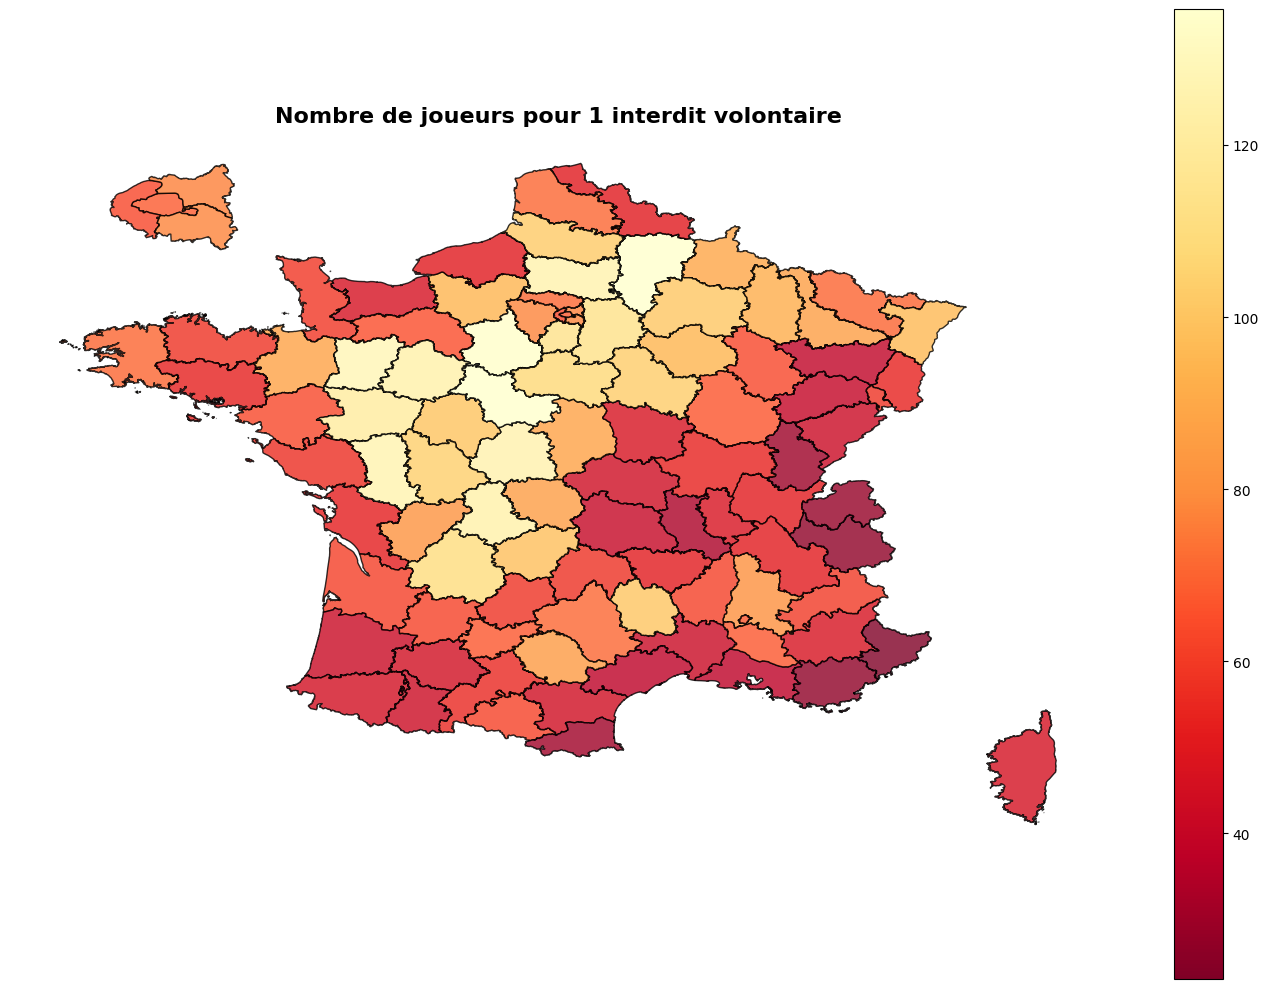

Top 5 des départements avec le moins de joueurs par interdit volontaire en 2024:
            nom_dep  joueurs_pour_interdit  nb_joueurs_uniques  nb_interdit_vol_2024
5   Alpes-Maritimes              23.060952             72642.0                3150.0
72           Savoie              26.584299             20656.0                 777.0
82              Var              26.845217             61744.0                2300.0
73     Haute-Savoie              28.144772             41992.0                1492.0
38             Jura              29.673973             10831.0                 365.0


  nom_dep  joueurs_pour_interdit
0  France              57.724105


In [125]:
top_5_interdit = joueurs_geo.nsmallest(5, 'joueurs_pour_interdit')[['nom_dep', 'joueurs_pour_interdit', 'nb_joueurs_uniques', 'nb_interdit_vol_2024']]


# Créer la carte avec la colonne "Nombre de joueurs de paris sportifs"
fig, ax = plt.subplots(figsize=(14, 10))

# Enlever les NaN pour la visualisation et garder le GeoDataFrame
joueurs_geo_map = joueurs_geo[joueurs_geo['joueurs_pour_interdit'].notna()].copy()
joueurs_geo_map = gpd.GeoDataFrame(joueurs_geo_map, geometry='geometry')

# Créer la choroplèthe (rouge pour valeurs faibles)
joueurs_geo_map.plot(
    column='joueurs_pour_interdit',
    ax=ax,
    legend=True,
    cmap='YlOrRd_r',
    edgecolor='k',
    alpha=0.8,
)

ax.set_title('Nombre de joueurs pour 1 interdit volontaire', fontsize=16, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Top 5 des départements avec le moins de joueurs par interdit volontaire en 2024:")
print(top_5_interdit.to_string())
print("\n")
print(joueurs_total[['nom_dep', 'joueurs_pour_interdit']])

En France, il faut 57 joueurs de jeux d'argent pour 1 interdit volontaire, tandis qu'en Alpes Maritimes, il en faut seulement 23, 27 dans le Var et 28 en Haute-Savoie. Cette carte renseigne sur l'intensité des comportements à risque par rapport aux joueurs, et pas par rapport à la population totale. Les départements en rouge ont un rapport inférieur à la moyenne nationale.

# CONCLUSION

Les données de l'ANJ permettent de voir des tendances sur le marché des jeux d'argent, en particulier on a noté une stabilisation du marché en termes d'opérateurs ainsi qu'une croissance soutenue depuis 15 ans, motivée par des mises, des produits bruts de jeux et le nombre de joueurs en constante augmentation. Cela a pour conséquence de réduire la marge des opérateurs, notamment pour les paris sportifs, mais cela peut aussi être le signe d'une intensification du jeu, hypothèse qu'on ne peut pas tester avec les données.

En effet, le nombre d'interdits volontaires est une donnée intéressante à analyse, mais ses disparités régionales nous posent des questions sur la connaissance et la diffusion du dispositif auprès de publics exposés aux nouveaux secteurs du marché, c'est-à-dire les paris en lignes par rapport aux casinos. Il semblerait qu'il y ait des mutations certaines chez les consommateurs dans la manière de jouer, et qu'avec ces données il soit compliqué de conclure à une intensification des pratiques de jeux et des comportements à risque. Une autre hypothèse à tester concerne le caractère urbain des joueurs, et cela pourrait être testé suite à une enquête de plus grande ampleur au niveau des individus, afin d'étudier plus en détail le profil, les motivations et les pratiques des joueurs sur un marché grandissant.

On suivra avec plaisir l'évolution de ces données pour les années futures.

# BONUS

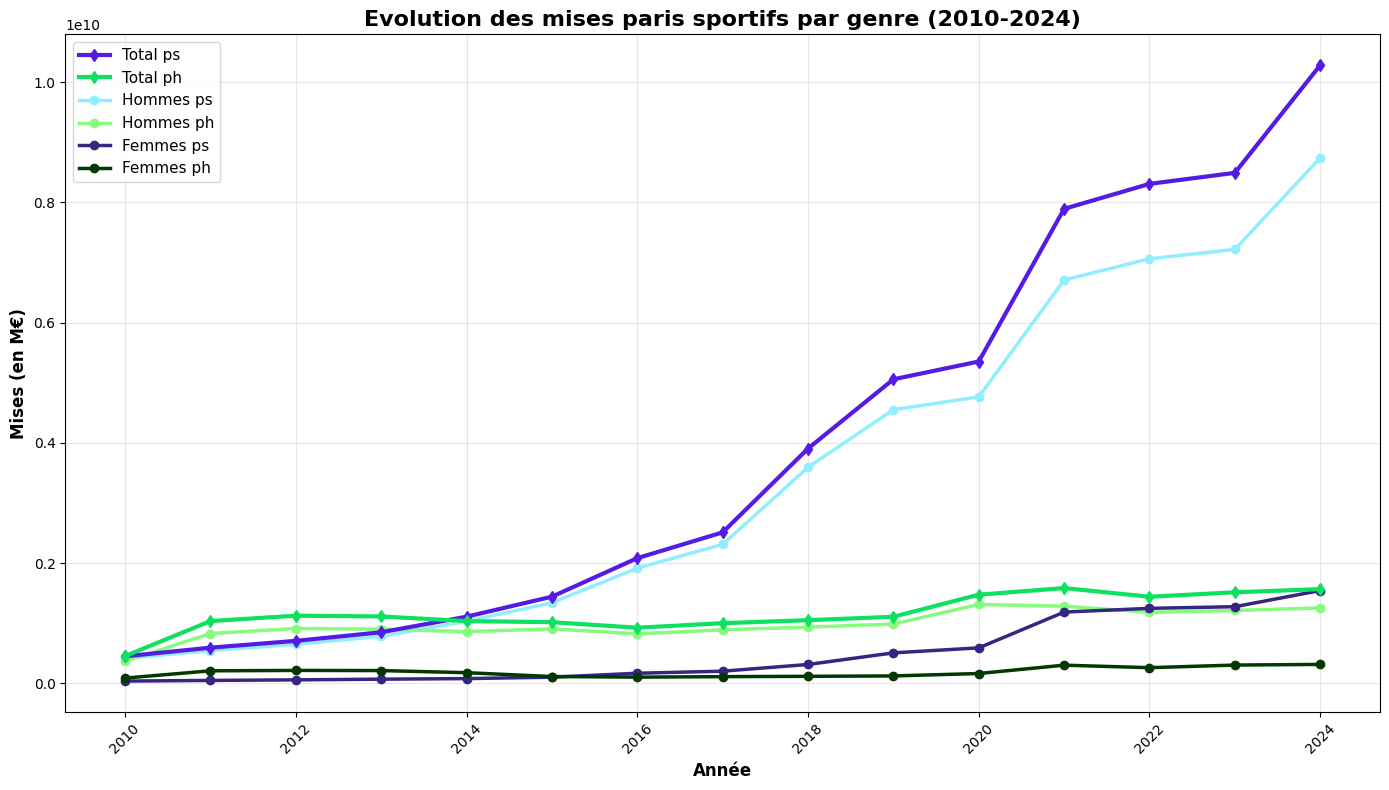

In [102]:
# Mises par sexe
sexe = ['hommes', 'femmes']
jeu = ['ps', 'ph']
couleurs_sports = ["#92EDFF", "#87FB7E", "#372681", "#033901"]

fig, ax = plt.subplots(figsize=(14, 8))

# Ajouter la courbe du total
valeurs_ps = marches['mises_ps'].values
valeurs_ph = marches['mises_ph'].values
ax.plot(marches['year'], valeurs_ps, marker='d', linewidth=3, label='Total ps', color="#541BE5", zorder=10)
ax.plot(marches['year'], valeurs_ph, marker='d', linewidth=3, label='Total ph', color="#0EE15F", zorder=10)

for idx, (sexe_ind, jeu_ind) in enumerate(itertools.product(sexe, jeu)):
    categorie = f'mises_{sexe_ind}_{jeu_ind}'
    if categorie in marches.columns:
        valeurs = marches[categorie].values
        ax.plot(marches['year'], valeurs, marker='o', linewidth=2.5, label=f"{sexe_ind.capitalize()} {jeu_ind}", color=couleurs_sports[idx])
        
ax.set_xlabel('Année', fontsize=12, fontweight='bold')
ax.set_ylabel('Mises (en M€)', fontsize=12, fontweight='bold')
ax.set_title('Evolution des mises paris sportifs par genre (2010-2024)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Les mises engagées par les joueurs sont majoritairement faites par des hommes, à plus de 90% pour chaque secteur de jeu. Au niveau des paris sportifs, on voit un décollage depuis 2020 chez les femmes en termes de mises.